# Imports

In [78]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from pytorchUtils import *

# Data Loading

In [1]:
data_filepath = os.path.join("data", "CERN", "ParticleClassification")
photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

class PhotonElectronDataset(Dataset):
    def __init__(self, _electron_filepath, _photon_filepath, transform=None, target_transform=None, low = 0, high = 1):
        global seed
        np.random.seed(seed)

        electronFile = h5py.File(_electron_filepath, "r")
        photonFile = h5py.File(_photon_filepath, "r")

        ElectronX, ElectronY = electronFile["X"], electronFile["y"]
        PhotonX, PhotonY = photonFile["X"], photonFile["y"]

        indexes = np.random.permutation(ElectronX.shape[0])

        _low = int(low * len(indexes))
        _high = int(high * len(indexes))

        self.X = np.concatenate([ElectronX[_low:_high, :,:,:], PhotonX[_low:_high, :,:,:]])
        self.Y = np.concatenate([ElectronY[_low:_high], PhotonY[_low:_high]])
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])
        image = self.X[idx, :, :, :]

        label = self.Y[idx,]
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
seed = 42
train_test_split = 0.8

print(f"Before {psutil.virtual_memory()[1] / (1024 * 1024  * 1024)}")
training_data = PhotonElectronDataset(electron_filepath, photon_filepath, transform=transforms.Compose([transforms.ToTensor()]), low=0, high=train_test_split)
validation_data = PhotonElectronDataset(electron_filepath, photon_filepath, transform=transforms.Compose([transforms.ToTensor()]), low=train_test_split, high=1)

print(f"Training dataset : {len(training_data)}")
print(f"Validation dataset : {len(validation_data)}")

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

print(f"After {psutil.virtual_memory()[1] / (1024 * 1024  * 1024)}")

Before 9.446773529052734
Training dataset : 398400
Validation dataset : 99600
After 5.624786376953125


# Util functions

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], "epochs" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    returnDict["best_model"] = model
    return returnDict



Device Used : cuda:0


In [71]:
def plotResults(results):
    plt.figure(figsize=(16,8))
    plt.subplot(2,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
    plt.show()

# Anything Working

## Model definition

In [59]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(32,32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 2]             514
Total params: 590,850
Trainable params: 590,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.29
----------------------------------------------------------------


## Training

In [73]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5037 Acc: 0.7527
val Loss: 0.6585 Acc: 0.6705

Epoch 1/24
----------
train Loss: 0.4805 Acc: 0.7666
val Loss: 0.6892 Acc: 0.6638

Epoch 2/24
----------
train Loss: 0.4585 Acc: 0.7799
val Loss: 0.7336 Acc: 0.6643

Epoch 3/24
----------
train Loss: 0.4384 Acc: 0.7909
val Loss: 0.7562 Acc: 0.6619

Epoch 4/24
----------
train Loss: 0.4205 Acc: 0.8017
val Loss: 0.8071 Acc: 0.6566

Epoch 5/24
----------
train Loss: 0.4037 Acc: 0.8101
val Loss: 0.8605 Acc: 0.6542

Epoch 6/24
----------
train Loss: 0.3890 Acc: 0.8186
val Loss: 0.8877 Acc: 0.6523

Epoch 7/24
----------
train Loss: 0.3293 Acc: 0.8524
val Loss: 0.9989 Acc: 0.6532

Epoch 8/24
----------
train Loss: 0.3103 Acc: 0.8621
val Loss: 1.0479 Acc: 0.6500

Epoch 9/24
----------
train Loss: 0.3001 Acc: 0.8671
val Loss: 1.0994 Acc: 0.6502

Epoch 10/24
----------
train Loss: 0.2926 Acc: 0.8712
val Loss: 1.1365 Acc: 0.6495

Epoch 11/24
----------
train Loss: 0.2864 Acc: 0.8740
val Loss: 1.1723 Acc: 0.6491

Ep

## Plots

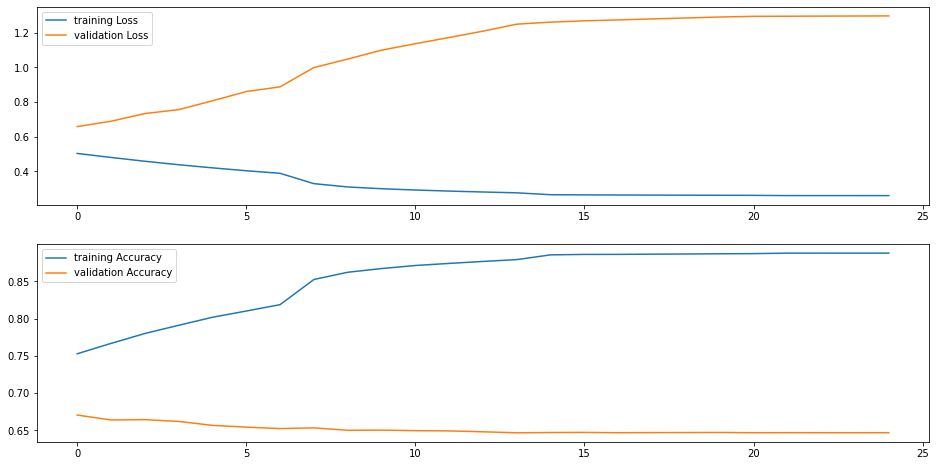

In [74]:
plotResults(results)

# Maxout Conv

In [119]:
import pytorchUtils

from importlib import reload
reload(pytorchUtils)

class MLP_with_Maxout(nn.Module):
    def __init__(self):
        super(MLP_with_Maxout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2 * 32 * 32, 256),
            pytorchUtils.MaxoutMLP(256, 5, 256),
            nn.Linear(256, 256),
            pytorchUtils.MaxoutMLP(256, 5, 128),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = MLP_with_Maxout()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(32, 32, 2))
## Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
         MaxoutMLP-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
         MaxoutMLP-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


# Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6499 Acc: 0.6251
val Loss: 0.6388 Acc: 0.6417

Epoch 1/24
----------
train Loss: 0.6273 Acc: 0.6549
val Loss: 0.6214 Acc: 0.6601

Epoch 2/24
----------
train Loss: 0.6089 Acc: 0.6769
val Loss: 0.6134 Acc: 0.6753

Epoch 3/24
----------
train Loss: 0.5964 Acc: 0.6889
val Loss: 0.6041 Acc: 0.6828

Epoch 4/24
----------
train Loss: 0.5877 Acc: 0.6959
val Loss: 0.6020 Acc: 0.6824

Epoch 5/24
----------
train Loss: 0.5800 Acc: 0.7025
val Loss: 0.5998 Acc: 0.6861

Epoch 6/24
----------
train Loss: 0.5739 Acc: 0.7072
val Loss: 0.5933 Acc: 0.6921

Epoch 7/24
----------
train Loss: 0.5448 Acc: 0.7297
val Loss: 0.5817 Acc: 0.7066

Epoch 8/24
----------
train Loss: 0.5360 Acc: 0.7361
val Loss: 0.5841 Acc: 0.7063

Epoch 9/24
----------
train Loss: 0.5305 Acc: 0.7402
val Loss: 0.5861 Acc: 0.7059

Epoch 10/24
----------
train Loss: 0.5253 Acc: 0.7434
val Loss: 0.5895 Acc: 0.7058

Epoch 11/24
----------
train Loss: 0.5198 Acc: 0.7463
val Loss: 0.5947 Acc: 0.7028

Ep

In [ ]:
plotResults(results)

# OK performance classical methods

In [107]:
from pytorchUtils import MaxoutMLP
MaxoutMLP(1, 2)

TypeError: __init__() takes 1 positional argument but 3 were given

# Vision Transformer

In [99]:
from importlib import reload
reload(pytorchUtils)

TypeError: __init__() takes 1 positional argument but 3 were given

# Graph Neural Network

In [24]:
print(np.random.random())
print(np.random.permutation(10))

0.7319939418114051
[9 7 0 3 5 8 2 1 6 4]
